<img src="images/ipsa_logo.png" width="100" align="right">

# Ma422- 2022/2023

# <font color='black'> Introduction to Machine Learning</font>

---

1. [Neural Networks from scratch](#NN)
 * [Model representation](#MR)
 * [Feedforward Propagation and Prediction](#MR)
 * [Backpropagation](#MR)
 * [Feedforward Propagation and Cost Function](#FeatureScaling)
  
3. [Neural Networks with scikit-learn](#logit)


---

The work has to be done in groups of 4 maximum. Each notebook must include student names below:

* Student 1: AMGHAR WASSIL
* Student 2: SINACOLA ENZO
* Student 3: PERDRIX BADIS
* Student 4: CHAOUKI ZAKARIA

Class: SET


## <font color='black'>Exercise 1: Code your first neural Neural Network</font>

---

In the previous session, you implemented multi-class logistic regression to recognize handwritten digits. Here, you will implement a neural network and apply it to the same exercise. The neural network will be able to represent complex models that form non-linear hypotheses. In the first part, you will be using parameters from a neural network that have already been trained. You will first implement the feedforward propagation to use the weights for prediction.

We start by loading and visualizing the dataset which contains the classical MNIST handwritten digits.





In [44]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
import utils

# tells matplotlib to embed plots within the notebook
%matplotlib inline

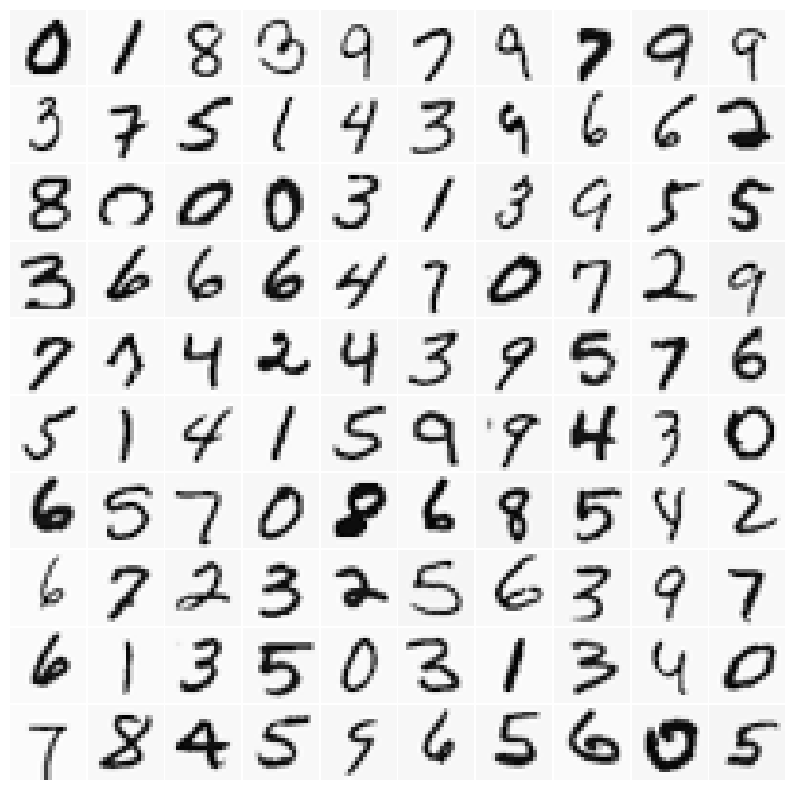

In [45]:
#  training data stored in arrays X, y
data = loadmat(os.path.join('Data', 'ex3data1.mat'))
X, y = data['X'], data['y'].ravel()

# set the zero digit to 0, rather than its mapped 10 in this dataset
y[y == 10] = 0

# get number of examples in dataset
m = y.size

# randomly permute examples, to be used for visualizing one 
# picture at a time
indices = np.random.permutation(m)

# Randomly select 100 data points to display
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
utils.displayData(sel)


### Model representation 

Your first neural network has 3 layers: an input layer, a hidden layer and an output layer. 

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained. These are stored in `ex3weights.mat`. The following cell loads those parameters into  `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [ ]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat(os.path.join('Data', 'ex3weights.mat'))

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
Theta2 = np.roll(Theta2, 1, axis=0)

###  Feedforward Propagation and Prediction

In the next cell implement the feedforward propagation for the neural network.

In [ ]:
#EDIT THIS CELL
def predict(Theta1, Theta2, X):    
  
    # Make sure the input has two dimensions
    if X.ndim == 1:
        X = X[None]  # promote to 2-dimensions
    
    # useful variables
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly 
    p = np.zeros(X.shape[0])

    # ====================== YOUR CODE HERE ======================

    # adding bias term to input
    X_copy = X.copy()

    X = np.concatenate([np.ones((m, 1)), X_copy], axis=1)

    # z = wx
    z2 = X @ Theta1.T
    # sigmoid for activation of second layer
    a2 = utils.sigmoid(z2)

    # adding bias term to 2nd layer (hidden layer)
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)

    # output layer
    z3 = a2 @ Theta2.T
    a3 = utils.sigmoid(z3)
    p = np.argmax(a3, axis=1)
    

    # ============================================================
    return p

Once you are done, call your predict function using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the accuracy is about 97.5%.

In [ ]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Now you can  display some images from the training set one at a time, while at the same time printing out the predicted label for the displayed image.

In [ ]:
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    utils.displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')

### Backpropagation


In the first part, you implemented forward propagation for neural networks and used it to predict handwritten digits with the weights provided. Now, you will implement the backpropagation algorithm to learn the parameters for the neural network.

In [ ]:
# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

### Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{-1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is the output of the NN, and K = 10 is the total number of possible labels.  You need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You need to implement the forward pass that computes  $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. 

In [ ]:
#EDIT THIS CELL
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for the 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================

    # --------------------------------
    # forward propagation
    # --------------------------------

    # bias term added
    X_copy = X.copy()
    X = np.concatenate([np.ones((m, 1)), X_copy], axis=1)

    # z = wx
    z2 = X @ Theta1.T
    a2 = utils.sigmoid(z2)
    # adding bias term to 2nd layer
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)

    # output layer
    z3 = a2 @ Theta2.T
    a3 = utils.sigmoid(z3)

    # --------------------------------

    # One-hot encoding
    y_matrix = np.zeros((m, num_labels))
    for i in range(m):
        y_matrix[i, y[i]] = 1

    # cost function
    J = (-1/m) * np.sum(y_matrix * np.log(a3) + (1 - y_matrix) * np.log(1 - a3))

    # --------------------------------
    # backpropagation
    # --------------------------------

    # Correction in output layer
    delta3 = a3 - y_matrix

    # Correction in hidden layer
    delta2 = (delta3 @ Theta2) * utils.sigmoid(np.concatenate([np.ones((m, 1)), z2], axis=1))
    delta2 = delta2[:, 1:]

    # gradient
    Theta1_grad = (1/m) * (delta2.T @ X)
    Theta2_grad = (1/m) * (delta3.T @ a2)

    # --------------------------------
    # regularization
    # --------------------------------

    # cost function updated with regularization
    J = J + (lambda_/(2*m)) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:])))

    # gradient updated with regularization
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_/m) * Theta1[:, 1:]
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_/m) * Theta2[:, 1:]

    # ============================================================

    
    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

Once you are done, call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`. You should see that the cost is about 0.287629.

In [ ]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)

### Regularized cost function

The cost function for neural networks with regularization is given by:


$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

You can assume that the neural network will only have 3 layers - an input layer, a hidden layer and an output layer. 

Recall that you should not be regularizing the terms that correspond to the bias. For the matrices `Theta1` and `Theta2`, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing `nnCostFunction` and then later add the cost for the regularization terms.

Once you are done, the next cell will call your `nnCostFunction` using the loaded set of parameters for `Theta1` and `Theta2`, and $\lambda = 1$. You should see that the cost is about 0.383770.

In [ ]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)

## <font color='black'>Exercise 2: Neural Networks with scikit-learn</font>

---

In this exercise we are interested in the identification of the digits data provided by scikit-learn. 

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
dataset = load_digits()
x=dataset.data
y=dataset.target

90% of the collection will be used for the training set (on which the classifier
will be trained) and 10% for the test set (on which the generalization capacity of the classifier will be assessed).

In [ ]:
# ====================== YOUR CODE HERE ======================

data_train, data_test, target_train, target_test = train_test_split(x, y, test_size=0.1)

# ============================================================

Train a classifier on (train_x, train_y). Then play around with MLPClassifier settings (number of hidden layers, number of neurons per layer, activation function, solver. . . ). 
comment on the results. 

In [ ]:
from sklearn.neural_network import MLPClassifier

# ====================== YOUR CODE HERE ======================

clf = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=1000)
clf.fit(data_train, target_train)

# ============================================================

The classifier performance can be evaluated on the test set in terms of the classification precision to identify which configuration of MLP works better. Compute that accuracy on the next cell. Conclude. 

In [ ]:
# ====================== YOUR CODE HERE ======================

target_pred = clf.predict(data_test)
accuracy = np.sum(target_pred == target_test) / len(target_test)
print('Accuracy: %.2f' % accuracy)
    
# ============================================================